In [13]:
import os.path as osp
import numpy as np
import pandas as pd
import pickle
import torch
from torch.nn.functional import one_hot

import matplotlib.pyplot as plt

from carla_visual.dataloaders.online_dataset import load_online_dataset, build_dataloader

from carla_visual.models.classifiers import PIECECNN
from carla_visual.models.generators import PIECEGenerator

from carla_visual.models.utils import load_model_weights

from carla_visual.models.autoencoder import AE
from carla_visual.evaluation import calculate_sparsity, calculate_proximity, calculate_validity
from carla_visual.evaluation import calculate_IM1, calculate_IM2

In [14]:
np.random.seed(0)
torch.manual_seed(0);

In [3]:
ds_name = 'MNIST'
data_root = 'D:\PycharmProjects\XAIRobustness\data\images'

train_data, test_data = load_online_dataset(ds_name, data_root, download=False)
print(f'Shape of the train set: ', train_data.data.shape)
print(f'Shape of the test set: ', test_data.data.shape)

Shape of the train set:  torch.Size([60000, 28, 28])
Shape of the test set:  torch.Size([10000, 28, 28])


In [4]:
input_shape = (28, 28, 1)
input_chn = input_shape[-1]
num_classes = 10
batch_size = 1
nz = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ngpu = 0 if device == 'cpu' else 1


In [5]:
train_dataloader, test_dataloader = build_dataloader([train_data, test_data], 
                                                      batch_size=batch_size, 
                                                      shuffle=False)

In [6]:
output_dir = 'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\models\weights\piece'
cnn_weights_file = 'cnn_weights.pth'
gen_weights_file = 'generator_weights.pth'

cnn = PIECECNN(input_chn, num_classes)
print('Total number of parameters in the CNN:', cnn.get_params_num())
cnn = load_model_weights(cnn, osp.join(output_dir, cnn_weights_file), device=device)

gen = PIECEGenerator(ngpu=ngpu)
gen = load_model_weights(gen, osp.join(output_dir, gen_weights_file), device=device)

Total number of parameters in the CNN: 143162


In [7]:
misclf_samples_info_path = r'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\recourse_methods\piece\misclassified_instances\misclassified_instances_and_latent_vectors.pickle'

with open(misclf_samples_info_path, 'rb') as f:
    misclf_samples_info = pickle.load(f)

In [8]:
cor_activations_lv_path = r'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\recourse_methods\piece\misclassified_instances\corrected_activations_and_latent_vectors.pickle'
with open(cor_activations_lv_path, 'rb') as f:
    cor_activations_and_lv = pickle.load(f)

# General evaluation

In [9]:
generated_cfe = [gen(item['corrected_latent_vector']) for item in cor_activations_and_lv]
generated_cfe = torch.concat(generated_cfe)

In [10]:
cfe_predictions = torch.argmax(cnn(generated_cfe)[0], axis=1)
cfe_predictions_encoded = one_hot(cfe_predictions)

In [11]:
target_labels = [item['label'].unsqueeze(0) for item in misclf_samples_info]
target_labels = torch.concat(target_labels)
target_labels_encoded = one_hot(target_labels, num_classes)

In [12]:
correct_clf_ind = [i for i, (sample, cf_pred) in enumerate(zip(misclf_samples_info, cfe_predictions)) 
                   if sample['label']==cf_pred]
incorrect_clf_ind = list(set(range(len(cfe_predictions))) - set(correct_clf_ind))

print('Number of correct CFEs: ', len(correct_clf_ind))
print('Number of incorrect CFEs: ', len(incorrect_clf_ind))

Number of correct CFEs:  19
Number of incorrect CFEs:  49


## Validity

In [15]:
print('Validity:', calculate_validity(cfe_predictions_encoded, target_labels_encoded))

Validity: 0.279


## IM1, IM2

In [18]:
ae_weights_dir = r'D:\PycharmProjects\XAIRobustness\CARLA_VISUAL\carla_visual\evaluation\interpretability_metrics_looveren\ae_weights_mnist'
ae_models_list = [load_model_weights(AE(), osp.join(ae_weights_dir, f'ae_{i}.pth'), device='cpu') 
                        for i in range(num_classes)]

In [19]:
ae_full = load_model_weights(AE(), osp.join(ae_weights_dir, 'ae_full.pth'), device='cpu') 

In [20]:
im1_results = []
im2_results = []

for gen_cf_image, pred, label in zip(generated_cfe, cfe_predictions, target_labels):
    ae_i_ind = pred.item()
    ae_t_ind = label.item()

    ae_i = ae_models_list[ae_i_ind]
    ae_t = ae_models_list[ae_t_ind]
    
    im1_results.append(calculate_IM1(gen_cf_image, ae_t, ae_i))
    im2_results.append(calculate_IM2(gen_cf_image, ae_t, ae_full))



In [21]:
print('Average IM1: ', sum(im1_results) / len(im1_results))
print('Average IM2: ', sum(im2_results) / len(im2_results))

Average IM1:  0.99235
Average IM2:  0.9607919307726728


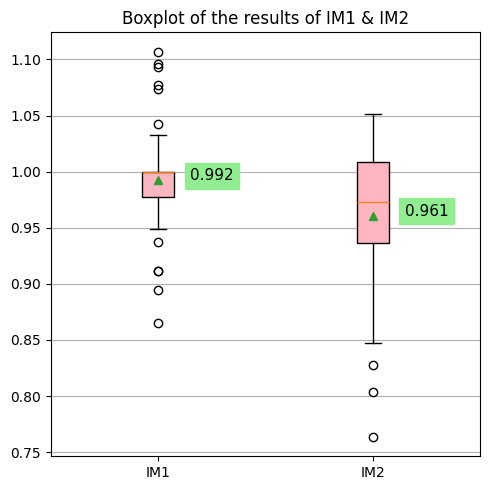

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))

bp = ax.boxplot([im1_results, im2_results], patch_artist=True, tick_labels=['IM1', 'IM2'], showmeans=True)

# Customize boxplot colors
colors = ['lightpink'] * len(bp['boxes'])
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add labels and title
ax.set_title('Boxplot of the results of IM1 & IM2')
# Add a grid for better readability
ax.yaxis.grid(True)

ax.text(1.15, np.mean(im1_results), str(round(np.mean(im1_results), 3)), 
        fontsize=11, color='black', backgroundcolor='lightgreen')
ax.text(2.15, np.mean(im2_results), str(round(np.mean(im2_results), 3)),
         fontsize=11, color='black', backgroundcolor='lightgreen')

# Show the plot
plt.tight_layout()
plt.show()

## Distances

### Diffusion distance

### Mahalanobis distance

Shows how close is an image to the training distribution of the targte (?) class -> Covariance mterix should be calculated for the distribution of images of a target class.

In [46]:
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv


def mahalanobis_distance(factuals: torch.Tensor, counterfactuals: torch.Tensor):
    """
    Calculates Mahalanobis distance

    Parameters
    ----------
     factuals: np.ndarray
            Normalized and encoded array with factual data.
            Shape: NxM
     counterfactuals: np.ndarray
            Normalized and encoded array with counterfactual data
            Shape: NxM

    Returns
    ---------
    A list of distances for each provided instance
    """
    # Calculate the covariance matrix of the original instances
    factuals_array = factuals.detach().numpy()
    counterfactuals_array = counterfactuals.detach().numpy()
    cov_matrix = np.cov(factuals_array, rowvar=False)

    # Compute the inverse of the covariance matrix
    inv_cov_matrix = inv(cov_matrix)

    # Calculate the Mahalanobis distance for each pair of instances
    mahalanobis_distances = []
    for factual, counterfactual in zip(factuals_array, counterfactuals_array):
        distance = mahalanobis(factual, counterfactual, inv_cov_matrix)
        mahalanobis_distances.append(distance)

    return mahalanobis_distances

In [25]:
# Misclassified counterfactuals 

correct_cf_samples_info = []
for ind in correct_clf_ind:
    cfe_predictions[ind]
    correct_cf_samples_info.append({'cf_image': generated_cfe[ind]})

In [ ]:
from sklearn.covariance import MinCovDet

class MahalanobisDistance:
    def __init__(self, target_class_samples):
        """
        Initialize with samples from the target class distribution
        
        Args:
            target_class_samples: torch.Tensor or numpy array of shape (n_samples, n_features)
                                containing samples from the target class
        """
        if isinstance(target_class_samples, torch.Tensor):
            target_class_samples = target_class_samples.cpu().numpy()
            
        self.mean = np.mean(target_class_samples, axis=0)
        
        # Calculate covariance matrix
        self.cov = MinCovDet().fit(target_class_samples)
        self.inv_cov = self.cov.precision_  # Use precision_ for inverse covariance
        
    def calculate(self, counterfactual):
        """
        Calculate Mahalanobis distance between counterfactual and target class distribution
        
        Args:
            counterfactual: torch.Tensor or numpy array of shape (n_features,)
                          containing the counterfactual example
                          
        Returns:
            float: Mahalanobis distance
        """
        if isinstance(counterfactual, torch.Tensor):
            counterfactual = counterfactual.cpu().numpy()
            
        if counterfactual.ndim == 2:
            counterfactual = counterfactual.squeeze()
            
        # Calculate difference from mean
        diff = counterfactual - self.mean
        
        # Calculate Mahalanobis distance
        mahalanobis_dist = np.sqrt(diff.dot(self.inv_cov).dot(diff))
        
        return mahalanobis_dist
    
    def calculate_batch(self, counterfactuals):
        """
        Calculate Mahalanobis distance for a batch of counterfactuals
        
        Args:
            counterfactuals: torch.Tensor or numpy array of shape (n_samples, n_features)
                           containing multiple counterfactual examples
                           
        Returns:
            numpy array: Array of Mahalanobis distances
        """
        if isinstance(counterfactuals, torch.Tensor):
            counterfactuals = counterfactuals.cpu().numpy()
            
        # Calculate differences from mean
        diff = counterfactuals - self.mean
        
        # Calculate Mahalanobis distances
        mahalanobis_dists = np.sqrt(np.sum(diff.dot(self.inv_cov) * diff, axis=1))
        
        return mahalanobis_dists

# Example usage
def demonstrate_mahalanobis():
    # Generate synthetic data for target class
    np.random.seed(42)
    n_samples = 1000
    n_features = 10
    
    # Create synthetic target class distribution (multivariate normal)
    mean = np.random.randn(n_features)
    cov = np.random.randn(n_features, n_features)
    cov = cov.T.dot(cov)  # Ensure positive semi-definite
    target_samples = np.random.multivariate_normal(mean, cov, n_samples)
    
    # Create counterfactual examples
    counterfactual_close = mean + np.random.randn(n_features) * 0.1  # Close to mean
    counterfactual_far = mean + np.random.randn(n_features) * 2.0    # Far from mean
    
    # Initialize calculator
    mahalanobis_calc = MahalanobisDistance(target_samples)
    
    # Calculate distances
    dist_close = mahalanobis_calc.calculate(counterfactual_close)
    dist_far = mahalanobis_calc.calculate(counterfactual_far)
    
    print(f"Mahalanobis distance for close counterfactual: {dist_close:.2f}")
    print(f"Mahalanobis distance for far counterfactual: {dist_far:.2f}")
    
    # Demonstrate batch calculation
    batch_counterfactuals = np.vstack([counterfactual_close, counterfactual_far])
    batch_distances = mahalanobis_calc.calculate_batch(batch_counterfactuals)
    
    print("\nBatch calculation results:")
    print(f"Distances: {batch_distances}")

if __name__ == "__main__":
    demonstrate_mahalanobis()

# Example with real model and data
def calculate_counterfactual_naturalness(model, data_loader, target_class, counterfactual):
    """
    Calculate how natural a counterfactual is with respect to the target class
    
    Args:
        model: trained model
        data_loader: DataLoader containing the training data
        target_class: int, the target class
        counterfactual: torch.Tensor, the counterfactual example
        
    Returns:
        float: Mahalanobis distance
    """
    # Collect features for target class
    target_features = []
    device = next(model.parameters()).device
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Get samples from target class
            target_mask = labels == target_class
            if not target_mask.any():
                continue
                
            target_inputs = inputs[target_mask]
            
            # Get features (assuming model has a feature extraction method)
            features = model.get_features(target_inputs)
            target_features.append(features.cpu().numpy())
    
    target_features = np.concatenate(target_features, axis=0)
    
    # Initialize calculator with target class features
    mahalanobis_calc = MahalanobisDistance(target_features)
    
    # Get features for counterfactual
    with torch.no_grad():
        counterfactual_features = model.get_features(counterfactual.unsqueeze(0))
    
    # Calculate distance
    distance = mahalanobis_calc.calculate(counterfactual_features)
    
    return distance

In [ ]:
# Calculate the covariance matrix of the original instances
factuals_array = factuals.detach().numpy()
counterfactuals_array = counterfactuals.detach().numpy()
cov_matrix = np.cov(factuals_array, rowvar=False)

# Compute the inverse of the covariance matrix
inv_cov_matrix = inv(cov_matrix)

# Calculate the Mahalanobis distance for each pair of instances
mahalanobis_distances = []
for factual, counterfactual in zip(factuals_array, counterfactuals_array):
    distance = mahalanobis(factual, counterfactual, inv_cov_matrix)
    mahalanobis_distances.append(distance)

### Proximity

Identifying proximity for the correctly classified counterfactuals 

In [143]:
proximity_results_cor = []

for ind in correct_clf_ind:
    # scaling the original and generated CFEs to the range of [0, 1]  
    cf = generated_cfe[ind]
    cf_norm = ((cf + 0.1307) * 0.3081).flatten()

    original_img = misclf_samples_info[ind]['image']
    original_img_norm = ((original_img + 0.1307) * 0.3081).flatten()

    proximity = calculate_proximity(original_img_norm, cf_norm)
    proximity_results_cor.append(round(proximity.detach().item(), 4))

avg_proximity_cor = np.mean(proximity_results_cor)


In [144]:
proximity_results_incor = []

for ind in incorrect_clf_ind:
    # scaling the original and generated CFEs to the range of [0, 1]  
    cf = generated_cfe[ind]
    cf_norm = ((cf + 0.1307) * 0.3081).flatten()

    original_img = misclf_samples_info[ind]['image']
    original_img_norm = ((original_img + 0.1307) * 0.3081).flatten()

    proximity = calculate_proximity(original_img_norm, cf_norm)
    proximity_results_incor.append(round(proximity.detach().item(), 4))

avg_proximity_incor = np.mean(proximity_results_incor)


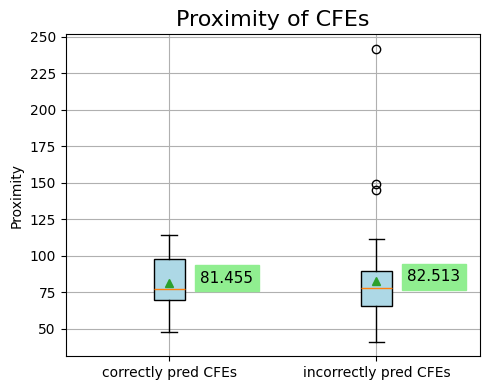

In [162]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(5, 4))

# Plotting the boxplots
#datasets = pd.DataFrame([proximity_results_cor, proximity_results_incor]).T
box_plot = ax.boxplot([proximity_results_cor,
                       proximity_results_incor], 
                       patch_artist=True, showmeans=True, tick_labels=['correctly pred CFEs', 
                                                                       'incorrectly pred CFEs'])

# Customize boxplot colors
colors = ['lightblue'] * len(box_plot['boxes'])
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

# Add labels and title
ax.set_ylabel('Proximity')
ax.set_title('Proximity of CFEs', fontsize=16)
ax.text(1.15, avg_proximity_cor, str(round(avg_proximity_cor, 3)), 
        fontsize=11, color='black', backgroundcolor='lightgreen')
ax.text(2.15, avg_proximity_incor, str(round(avg_proximity_incor, 3)), 
        fontsize=11, color='black', backgroundcolor='lightgreen')

# Add a grid for better readability
ax.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Sparsity

In [ ]:
sparsity_results_incor = []
sparsity_results_cor = []

for ind in incorrect_clf_ind:
    # scaling the original and generated CFEs to the range of [0, 1]  
    cf = generated_cfe[ind]
    cf_norm = ((cf + 0.1307) * 0.3081).flatten()

    original_img = misclf_samples_info[ind]['image']
    original_img_norm = ((original_img + 0.1307) * 0.3081).flatten()

    proximity = calculate_proximity(original_img_norm, cf_norm)
    proximity_results_incor.append(round(proximity.detach().item(), 4))

avg_proximity_incor = np.mean(proximity_results_incor)

# Robustness evaluation

## Invalidation rate

In [24]:
import torch
from tqdm import tqdm
from torch.distributions.multivariate_normal import MultivariateNormal

In [25]:
def perturb_sample(x, n_samples, perturb_magnitude):
    
    # stack copies of this sample, i.e. n rows of x.
    X = x.repeat(n_samples, 1, 1, 1)
    
    # sample normal distributed values
    sigma = torch.eye(x.shape[1]) * perturb_magnitude
    eps = MultivariateNormal(
        loc=torch.zeros(x.shape[1]), covariance_matrix=sigma
    ).sample((n_samples,))
    eps = eps.unsqueeze(-1).unsqueeze(-1)
    
    return X + eps

In [26]:
def calculate_invalidation_rate(counterfactuals, classifier, n_samples, perturb_magnitude):
    result = []
    for x in tqdm(counterfactuals):
        if len(x.shape) < 4:
            x = x.unsqueeze(0)
            
        cf_prediction = one_hot(torch.argmax(classifier(x)[0], axis=1), num_classes)
        cf_prediction = cf_prediction.repeat(n_samples, 1) 

        X_pert = perturb_sample(x, n_samples, perturb_magnitude=perturb_magnitude)
        cf_pert_prediction = one_hot(torch.argmax(classifier(X_pert)[0], axis=1), num_classes)

        hamming_distance = torch.sum(cf_pert_prediction != cf_prediction, axis=1)
        incorrect_explanations_num = torch.where(hamming_distance==2)[0].shape[0]

        invalidation_rate = incorrect_explanations_num / cf_prediction.shape[0]

        result.append(invalidation_rate)
    return result

In [27]:
perturb_magnitudes = [0.01, 0.015, 0.02, 0.025]
invalidation_rates = []
for perturb_magnitude in perturb_magnitudes:
    invalidation_rates.append(calculate_invalidation_rate(generated_cfe, cnn, n_samples=100,
                                                         perturb_magnitude=perturb_magnitude))

100%|██████████| 68/68 [00:01<00:00, 62.93it/s]


## Visualize invalidation rates

C:\Users\sahat\AppData\Local\Temp\ipykernel_58212\3095175641.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax.boxplot(datasets, patch_artist=True, labels=labels)


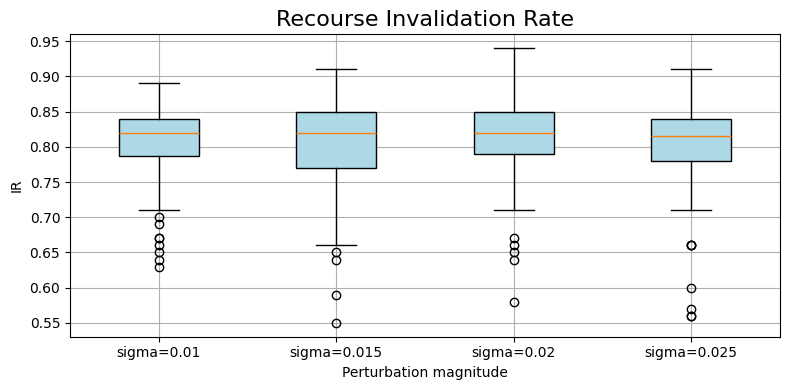

In [33]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(8, 4))

# Plotting the boxplots
datasets = pd.DataFrame(invalidation_rates).T
labels = [f'sigma={sigma}' for sigma in perturb_magnitudes]

box_plot = ax.boxplot(datasets, patch_artist=True, labels=labels)

# Customize boxplot colors
colors = ['lightblue'] * len(box_plot['boxes'])
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

# Add labels and title
ax.set_xlabel('Perturbation magnitude')
ax.set_ylabel('IR')
ax.set_title('Recourse Invalidation Rate', fontsize=16)

# Add a grid for better readability
ax.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Manifold Topology Divergence